Dataset URL

https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "/content/drive/MyDrive/archive (1).zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!')

Streaming output truncated to the last 5000 lines.
cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png 2019-10-14 08:19:22         8513
cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png 2019-10-14 08:19:22        11145
cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png 2019-10-14 08:19:22        11113
cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png 2019-10-14 08:19:22        11492
cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png 2019-10-14 08:19:22        10545
cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png 2019-10-14 08:19:22         9976
cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png 2019-10-14 08:19:22        11303
cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png 2019-10-14 08:19:22         8894
cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102

In [4]:
os.makedirs('train/Uninfected')
os.makedirs('train/Parasitized')

os.makedirs('test/Uninfected')
os.makedirs('test/Parasitized')

In [5]:
# Function to split source data into train and test
def split_data(class_source_path, class_train_path, class_test_path, test_size):
    for i, src_img_name in enumerate(os.listdir(class_source_path), start=1):
        src_url = os.path.join(class_source_path, src_img_name)
        src_img = open(src_url, 'rb')
        if '.png' in src_img_name.lower():   
            if i <= test_size:
                dest_url = os.path.join(class_test_path,'{}.png'.format(i))
            else:
                dest_url = os.path.join(class_train_path,'{}.png'.format(i))
            dest_img = open(dest_url, 'wb')
            dest_img.write(src_img.read())
            src_img.close()
            dest_img.close()
        else:
            print("Invalid image : ",src_url)

In [6]:
TEST_SIZE = 3780

source_parasitized = '/content/cell_images/Parasitized/'
train_parasitized ='train/Parasitized/'
test_parasitized = 'test/Parasitized/'
split_data(source_parasitized, train_parasitized, test_parasitized, test_size=TEST_SIZE)

Invalid image :  /content/cell_images/Parasitized/Thumbs.db


In [7]:
source_uninfected = '/content/cell_images/Uninfected/'
train_uninfected = 'train/Uninfected/'
test_uninfected = 'test/Uninfected/'
split_data(source_uninfected, train_uninfected, test_uninfected, test_size=TEST_SIZE)

Invalid image :  /content/cell_images/Uninfected/Thumbs.db


In [8]:
# Overview of train and test datasets
print("Train parasitized images :",len(os.listdir(train_parasitized)))
print("Train uninfected images :",len(os.listdir(train_uninfected)))
print("Total training images :",len(os.listdir(train_parasitized))+ len(os.listdir(train_uninfected)))
print()
print("Test parasitized images :",len(os.listdir(test_parasitized)))
print("Test uninfected images :",len(os.listdir(test_uninfected)))
print("Total testing images :",len(os.listdir(test_parasitized))+ len(os.listdir(test_uninfected)))

Train parasitized images : 10000
Train uninfected images : 10000
Total training images : 20000

Test parasitized images : 3779
Test uninfected images : 3779
Total testing images : 7558


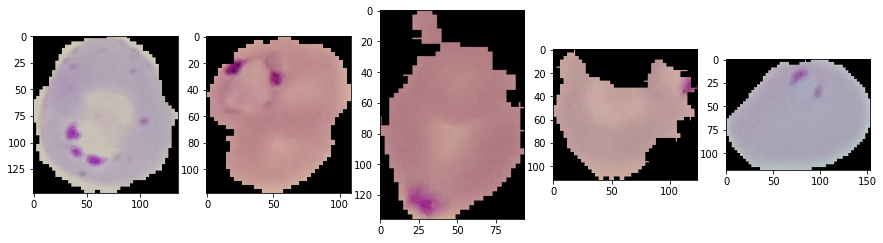

In [9]:
#Dispalying Parasitized images
f,axes = plt.subplots(1,5, figsize=(15,4))
images = os.listdir(train_parasitized)[:5] # 5 images
for i, img in enumerate(images):
    img = plt.imread(os.path.join(train_parasitized,img))
    axes[i].imshow(img)

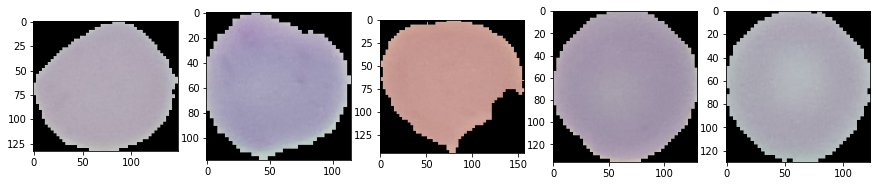

In [10]:
#Displaying uninfected images
f,axes = plt.subplots(1,5, figsize=(15,4))
images = os.listdir(train_uninfected)[:5]
for i, img in enumerate(images):
    img = plt.imread(os.path.join(train_uninfected,img))
    axes[i].imshow(img)

In [11]:
TRAIN_PATH = 'train'
TEST_PATH = 'test'
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
training_set = train_datagen.flow_from_directory(directory=TRAIN_PATH,target_size=IMAGE_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',shuffle=True)
testing_set = test_datagen.flow_from_directory(directory=TEST_PATH,target_size=IMAGE_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',shuffle=True)

Found 20000 images belonging to 2 classes.
Found 7558 images belonging to 2 classes.


In [13]:
print(training_set.class_indices)
print(testing_set.class_indices)

{'Parasitized': 0, 'Uninfected': 1}
{'Parasitized': 0, 'Uninfected': 1}


In [14]:
#https://neurohive.io/en/popular-networks/vgg16/
model_vgg16 = Sequential()
#CONVOLUTION1
model_vgg16.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#MAXPOOLING1
model_vgg16.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#CONVOLUTION2
model_vgg16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#MAXPOOLING2
model_vgg16.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#CONVOLUTION3
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#MAXPOOLING3
model_vgg16.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#CONVOLUTION4
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#MAXPOOLING4
model_vgg16.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#CONVOLUTION5
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#MAXPOOLING5
model_vgg16.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
#FLATTEN
model_vgg16.add(Flatten())
model_vgg16.add(Dense(units=2, activation="softmax"))

In [15]:
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

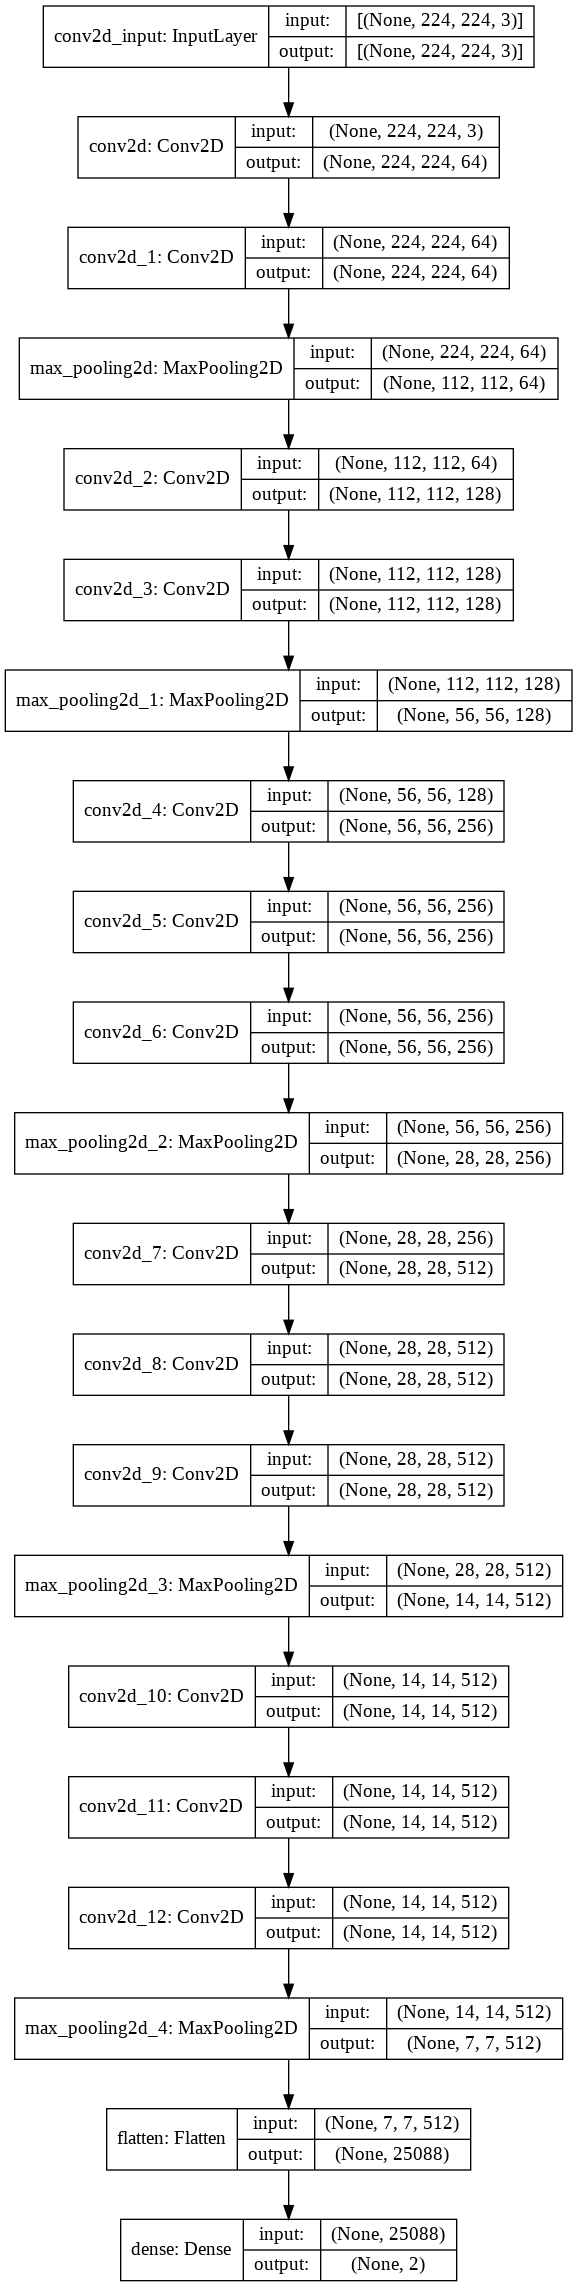

In [16]:
tf.keras.utils.plot_model(model_vgg16,show_shapes=True, show_layer_names=True)

In [17]:
model_vgg16.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [19]:
history = model_vgg16.fit_generator(training_set,validation_data=testing_set,epochs=15,steps_per_epoch=len(training_set),
                                    validation_steps=len(testing_set))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
625/625 [==============================] - 370s 524ms/step - loss: 0.7108 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/15
625/625 [==============================] - 323s 516ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/15
625/625 [==============================] - 322s 515ms/step - loss: 0.6932 - accuracy: 0.5045 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/15
625/625 [==============================] - 322s 514ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/15
625/625 [==============================] - 322s 516ms/step - loss: 0.6933 - accuracy: 0.4904 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/15
625/625 [==============================] - 323s 516ms/step - loss: 0.6932 - accuracy: 0.4916 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/15
625/625 [==============================] - 323s 517ms/step - loss: 0.6932 - accuracy: 0.5037 - val_loss: 0.6932 -

In [20]:
model_vgg16.save("/content/drive/MyDrive/malaria detection/weights/vgg16.h5")

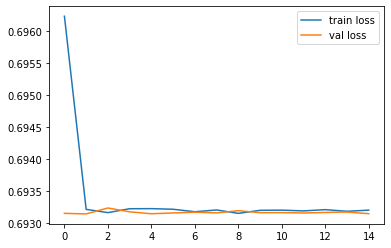

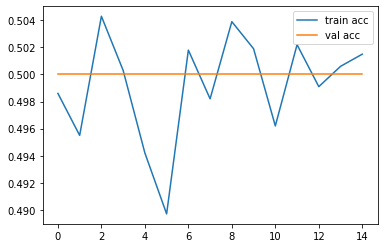

In [21]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()